# **Libraries and Resources**

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')
nltk.download('punkt_tab')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# **Loading the dataset**

In [120]:
data = pd.read_csv('/content/sample_data/spam_ham_dataset.csv')
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [122]:
data.shape

(5171, 4)

In [123]:
data.columns

Index(['Unnamed: 0', 'label', 'text', 'label_num'], dtype='object')

In [124]:
data["Message Length"]=data["text"].apply(len)

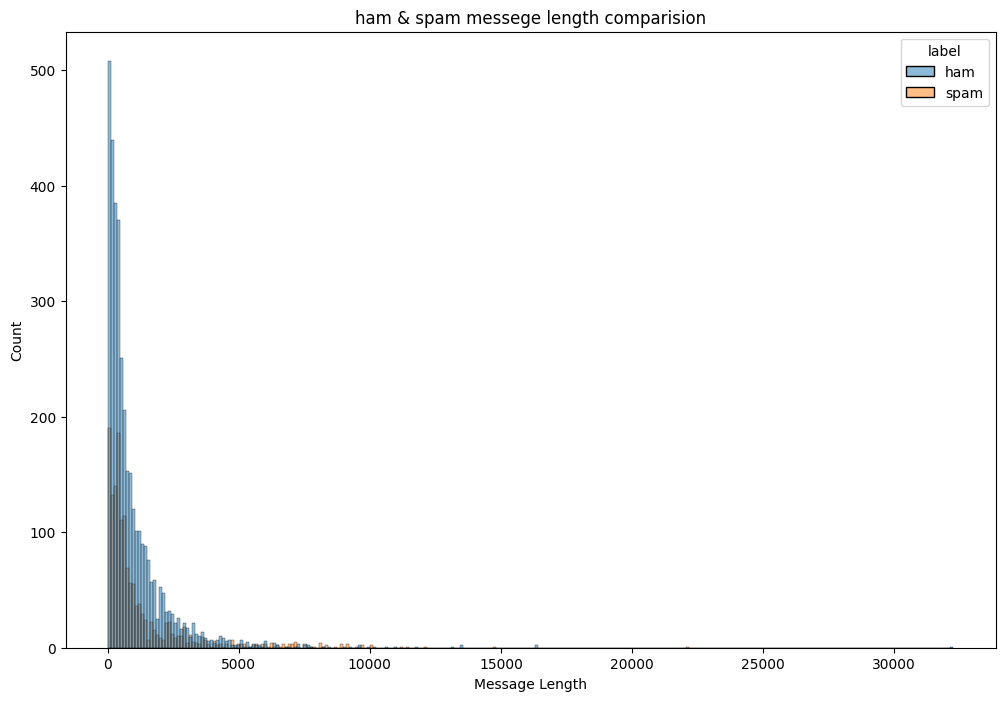

In [125]:
fig=plt.figure(figsize=(12,8))
sns.histplot(
    x=data["Message Length"],
    hue=data["label"]
)
plt.title("ham & spam messege length comparision")
plt.show()

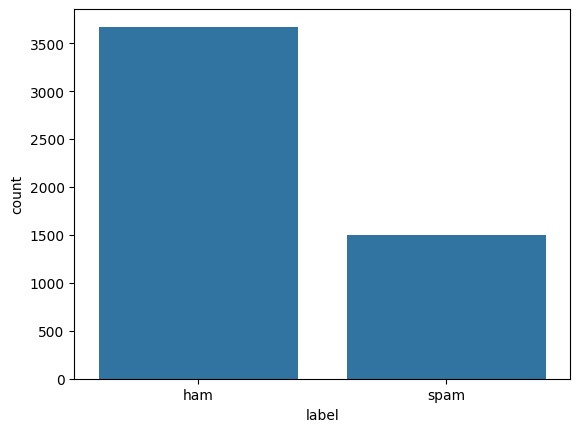

In [126]:
sns.countplot(x='label', data=data)
plt.show()

In [127]:
ham_desc=data[data["label"]=="ham"]["Message Length"].describe()
spam_desc=data[data["label"]=="spam"]["Message Length"].describe()

print("Ham Messege Length Description:\n",ham_desc)
print("************************************")
print("Spam Message Length Description:\n",spam_desc)

Ham Messege Length Description:
 count     3672.000000
mean       977.008170
std       1382.827493
min         18.000000
25%        231.750000
50%        530.000000
75%       1227.250000
max      32258.000000
Name: Message Length, dtype: float64
************************************
Spam Message Length Description:
 count     1499.000000
mean      1223.256171
std       1825.986210
min         11.000000
25%        283.000000
50%        576.000000
75%       1253.500000
max      22073.000000
Name: Message Length, dtype: float64


In [128]:
data.describe(include="all")

,Unnamed: 0,label,text,label_num,Message Length
count,5171.000000,5171,5171,5171.000000,5171.000000
unique,NaN,2,4993,NaN,NaN
top,NaN,ham,Subject: calpine daily gas nomination\r\n>\r\n...,NaN,NaN
freq,NaN,3672,20,NaN,NaN
mean,2585.000000,NaN,NaN,0.289886,1048.391994
std,1492.883452,NaN,NaN,0.453753,1528.513435
min,0.000000,NaN,NaN,0.000000,11.000000
25%,1292.500000,NaN,NaN,0.000000,244.000000
50%,2585.000000,NaN,NaN,0.000000,540.000000
75%,3877.500000,NaN,NaN,1.000000,1237.000000


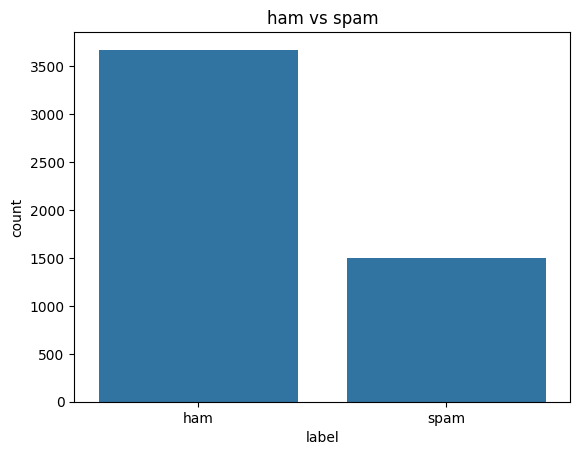

In [129]:
sns.countplot(
    data=data,
    x="label"
)
plt.title("ham vs spam")
plt.show()

In [130]:
ham_count=data["label"].value_counts()[0]
spam_count=data["label"].value_counts()[1]

total_count=data.shape[0]

print("Ham contains:{:.2f}% of total data.".format(ham_count/total_count*100))
print("Spam contains:{:.2f}% of total data.".format(spam_count/total_count*100))

Ham contains:71.01% of total data.
Spam contains:28.99% of total data.


# **Balancing the Data**

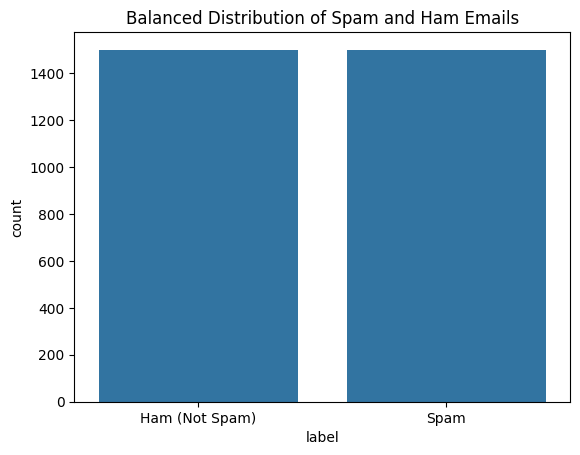

In [131]:
ham_msg = data[data['label'] == 'ham']
spam_msg = data[data['label'] == 'spam']

# Downsample Ham emails to match the number of Spam emails
ham_msg_balanced = ham_msg.sample(n=len(spam_msg), random_state=42)

# Combine balanced data
balanced_data = pd.concat([ham_msg_balanced, spam_msg]).reset_index(drop=True)

# Visualize the balanced dataset
sns.countplot(x='label', data=balanced_data)
plt.title("Balanced Distribution of Spam and Ham Emails")
plt.xticks(ticks=[0, 1], labels=['Ham (Not Spam)', 'Spam'])
plt.show()

# **Text Cleanup**

In [132]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

,Unnamed: 0,label,text,label_num,Message Length
0,3444,ham,: conoco - big cowboy\r\ndarren :\r\ni ' m not...,0,618
1,2982,ham,: feb 01 prod : sale to teco gas processing\r\...,0,367
2,2711,ham,": california energy crisis\r\ncalifornia  , s...",0,7547
3,3116,ham,: re : nom / actual volume for april 23 rd\r\n...,0,409
4,1314,ham,: eastrans nomination changes effective 8 / 2 ...,0,219


In [133]:
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,Unnamed: 0,label,text,label_num,Message Length
0,3444,ham,conoco big cowboy\r\ndarren \r\ni m not sur...,0,618
1,2982,ham,feb 01 prod sale to teco gas processing\r\ns...,0,367
2,2711,ham,california energy crisis\r\ncalifornia  s p...,0,7547
3,3116,ham,re nom actual volume for april 23 rd\r\nwe ...,0,409
4,1314,ham,eastrans nomination changes effective 8 2 0...,0,219


In [134]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output


balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,Unnamed: 0,label,text,label_num,Message Length
0,3444,ham,conoco big cowboy darren sure help know else a...,0,618
1,2982,ham,feb 01 prod sale teco gas processing sale deal...,0,367
2,2711,ham,california energy crisis california  power cr...,0,7547
3,3116,ham,nom actual volume april 23 rd agree eileen pon...,0,409
4,1314,ham,eastrans nomination changes effective 8 2 00 p...,0,219


# **Word Cloud**

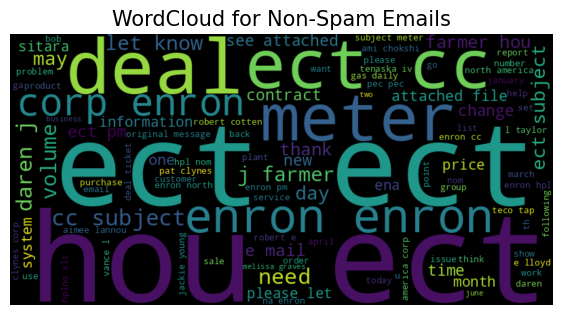

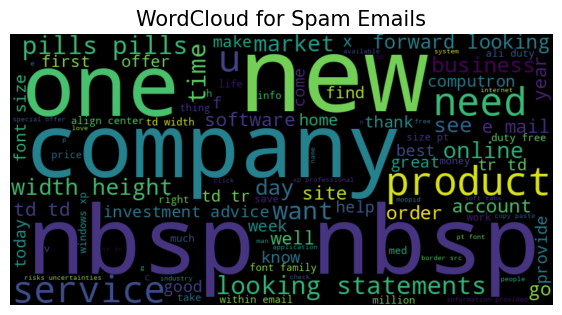

In [135]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
    wc = WordCloud(background_color='black', max_words=100, width=800, height=400).generate(email_corpus)
    plt.figure(figsize=(7, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} Emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['label'] == 'ham'], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['label'] == 'spam'], typ='Spam')

# **Padding & Tokenization**

In [136]:
train_X, test_X, train_Y, test_Y = train_test_split(
    balanced_data['text'], balanced_data['label'], test_size=0.2, random_state=42
)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

max_len = 100  # Maximum sequence length
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

train_Y = (train_Y == 'spam').astype(int)
test_Y = (test_Y == 'spam').astype(int)

# **Model Definition**

In [137]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_len),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# **Training**

In [138]:
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

history = model.fit(
    train_sequences, train_Y,
    validation_data=(test_sequences, test_Y),
    epochs=20,
    batch_size=32,
    callbacks=[lr, es]
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5285 - loss: 0.6705 - val_accuracy: 0.9267 - val_loss: 0.3189 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9361 - loss: 0.2615 - val_accuracy: 0.9317 - val_loss: 0.2259 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9360 - loss: 0.2180 - val_accuracy: 0.9300 - val_loss: 0.2359 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9461 - loss: 0.1920 - val_accuracy: 0.9300 - val_loss: 0.2314 - learning_rate: 0.0010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9455 - loss: 0.1889 - val_accuracy: 0.9333 - val_loss: 0.2247 - learning_rate: 5.0000e-04
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9467 - loss: 0.1913 - val_accuracy: 0.9367 - val_loss: 0.2213 - learning_rate: 5.0000e-04
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9586 - loss: 0.1619 - va

In [139]:
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9436 - loss: 0.2146
Test Loss : 0.22737452387809753
Test Accuracy : 0.9399999976158142


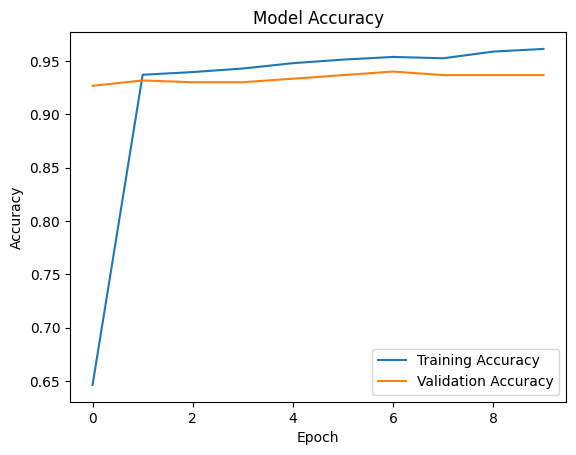

In [140]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()